<a href="https://colab.research.google.com/github/solankiharsh/Fraud_Detection/blob/master/fraud_detection_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline
import argparse
import logging
import os
from itertools import combinations

In [2]:
#! git clone https://github.com/awslabs/sagemaker-graph-fraud-detection

In [ ]:
data_dir = '/content/drive/My Drive/ieee-fraud-detection'

In [ ]:
train_identity = pd.read_csv(f'{data_dir}/train_identity.csv')
train_transaction = pd.read_csv(f'{data_dir}/train_transaction.csv')
test_identity = pd.read_csv(f'{data_dir}/test_identity.csv')
test_transaction = pd.read_csv(f'{data_dir}/test_transaction.csv')
sub = pd.read_csv(f'{data_dir}/sample_submission.csv')
# Combining identity and transaction
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

In [ ]:
print('There are {} rows and {} columns in the train dataset.'.format(train.shape[0],train.shape[1]))
print('There are {} rows and {} columns in the test dataset.'.format(test.shape[0],test.shape[1]))

There are 590540 rows and 434 columns in the train dataset.
There are 506691 rows and 433 columns in the test dataset.


In [ ]:
print(f'There are {test.isnull().any().sum()} columns in test dataset with missing values.')

There are 385 columns in test dataset with missing values.


In [ ]:
def null_values(df): #creates a function with below logic
        mis_val = df.isnull().sum() #gives sum of missing values (null values)
        mis_val_percent = 100 * df.isnull().sum() / len(df) #getting percentage of missing values
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1) #creating a DF containing missing value count and it's percentage
        mis_val_table_ren_columns = mis_val_table.rename( 
        columns = {0 : 'Missing Values', 1 : '% of Total Values'}) #renaming the columns
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1) #getting the percentage of missing values in descending order and rounding it to 1 decimal
        print ("Dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.") #printing number of columns and missing value count
        return mis_val_table_ren_columns

In [ ]:
# Missing values statistics
miss_values = null_values(train)
miss_values.head(20)

Dataframe has 434 columns.
There are 414 columns that have missing values.


,Missing Values,% of Total Values
id_24,585793,99.2
id_25,585408,99.1
id_07,585385,99.1
id_08,585385,99.1
id_21,585381,99.1
id_26,585377,99.1
id_27,585371,99.1
id_23,585371,99.1
id_22,585371,99.1
dist2,552913,93.6


In [ ]:
#drop_list = sorted(list(missing_features[missing_features > 0.9].index)) #creating list to store the column names with over 90% missing values
#print(drop_list)

In [ ]:
#number of features to be dropped?
#len(drop_list)

In [ ]:
#Dropping these features
#train.drop(drop_list, axis=1, inplace=True)

In [ ]:
#print('Now we are left with {} columns'.format(train.shape[1]))
#print('The remaining columns are as follows:')
#print(train.columns)

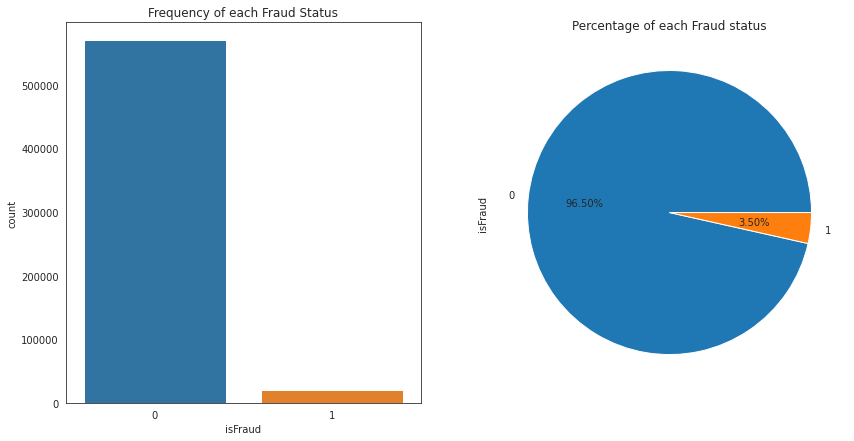

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(14,7))
sns.countplot(x='isFraud',data=train,ax=axs[0])
axs[0].set_title("Frequency of each Fraud Status")
train.isFraud.value_counts().plot(x=None,y=None, kind='pie', ax=axs[1],autopct='%1.2f%%')
axs[1].set_title("Percentage of each Fraud status")
plt.show()

In [ ]:
def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--data-dir', type=str, default='/content/drive/My Drive/ieee-fraud-detection')
    parser.add_argument('--output-dir', type=str, default='/content/drive/My Drive/ieee-fraud-detection/Output')
    parser.add_argument('--transactions', type=str, default='train_transaction.csv', help='name of file with transactions')
    parser.add_argument('--identity', type=str, default='train_identity.csv', help='name of file with identity info')
    parser.add_argument('--id-cols', type=str, default='', help='comma separated id cols in transactions table')
    parser.add_argument('--cat-cols', type=str, default='', help='comma separated categorical cols in transactions')
    parser.add_argument('--train-data-ratio', type=float, default=0.8, help='fraction of data to use in training set')
    parser.add_argument('--construct-homogeneous', action="store_true", default=False,
                        help='use bipartite graphs edgelists to construct homogenous graph edgelist')
    return parser.parse_args()

In [ ]:
data_dir = '/content/drive/My Drive/ieee-fraud-detection'
transaction_data = 'train_transaction.csv'
identity_data = 'train_identity.csv'
train_data_ratio = 0.8
output_dir = '/content/drive/My Drive/ieee-fraud-detection/Output'

In [ ]:
def load_data(data_dir, transaction_data, identity_data, train_data_ratio, output_dir):
    transaction_df = pd.read_csv(os.path.join(data_dir, transaction_data))
    logging.info("Shape of transaction data is {}".format(transaction_df.shape))
    logging.info("# Tagged transactions: {}".format(len(transaction_df) - transaction_df.isFraud.isnull().sum()))

    identity_df = pd.read_csv(os.path.join(data_dir, identity_data))
    logging.info("Shape of identity data is {}".format(identity_df.shape))

    # extract out transactions for test/validation
    n_train = int(transaction_df.shape[0]*train_data_ratio)
    test_ids = transaction_df.TransactionID.values[n_train:]

    get_fraud_frac = lambda series: 100 * sum(series)/len(series)
    logging.info("Percent fraud for train transactions: {}".format(get_fraud_frac(transaction_df.isFraud[:n_train])))
    logging.info("Percent fraud for test transactions: {}".format(get_fraud_frac(transaction_df.isFraud[n_train:])))
    logging.info("Percent fraud for all transactions: {}".format(get_fraud_frac(transaction_df.isFraud)))

    with open(os.path.join(output_dir, 'test.csv'), 'w') as f:
        f.writelines(map(lambda x: str(x) + "\n", test_ids))
    logging.info("Wrote test to file: {}".format(os.path.join(output_dir, 'test.csv')))

    return transaction_df, identity_df, test_ids

In [ ]:
#load_data(data_dir, transaction_data, identity_data, train_data_ratio, output_dir)

In [ ]:
object_columns_df = train.select_dtypes(include=['object'])
print(object_columns_df.iloc[0])

ProductCD               W
card4            discover
card6              credit
P_emaildomain         NaN
R_emaildomain         NaN
M1                      T
M2                      T
M3                      T
M4                     M2
M5                      F
M6                      T
M7                    NaN
M8                    NaN
M9                    NaN
id_12                 NaN
id_15                 NaN
id_16                 NaN
id_23                 NaN
id_27                 NaN
id_28                 NaN
id_29                 NaN
id_30                 NaN
id_31                 NaN
id_33                 NaN
id_34                 NaN
id_35                 NaN
id_36                 NaN
id_37                 NaN
id_38                 NaN
DeviceType            NaN
DeviceInfo            NaN
Name: 0, dtype: object


In [ ]:
categorical = object_columns_df.columns
for name in categorical:
    print(name,':')
    print(object_columns_df[name].value_counts(),'\n')

ProductCD :
W    439670
C     68519
R     37699
H     33024
S     11628
Name: ProductCD, dtype: int64 

card4 :
visa                384767
mastercard          189217
american express      8328
discover              6651
Name: card4, dtype: int64 

card6 :
debit              439938
credit             148986
debit or credit        30
charge card            15
Name: card6, dtype: int64 

P_emaildomain :
gmail.com           228355
yahoo.com           100934
hotmail.com          45250
anonymous.com        36998
aol.com              28289
comcast.net           7888
icloud.com            6267
outlook.com           5096
msn.com               4092
att.net               4033
live.com              3041
sbcglobal.net         2970
verizon.net           2705
ymail.com             2396
bellsouth.net         1909
yahoo.com.mx          1543
me.com                1522
cox.net               1393
optonline.net         1011
charter.net            816
live.com.mx            749
rocketmail.com         664
ma

ValueError: ignored

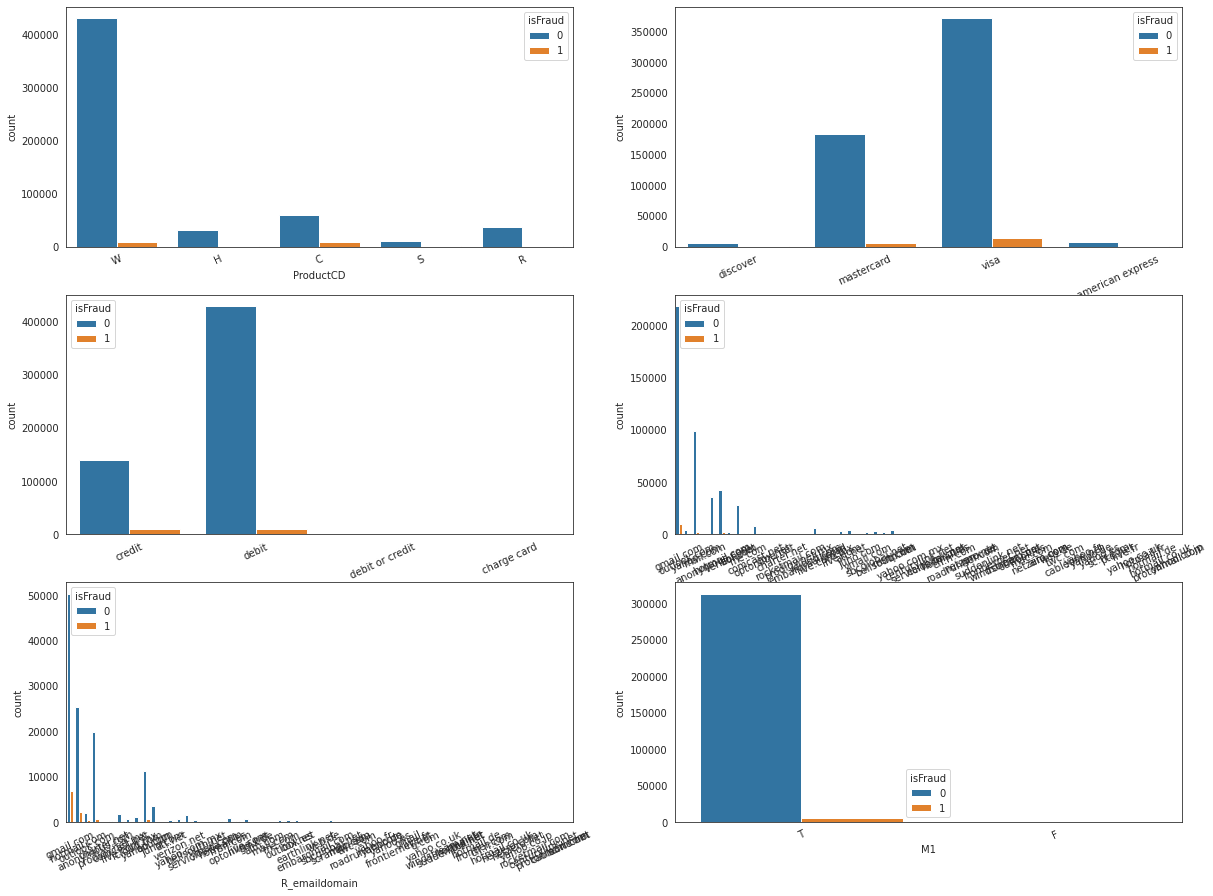

In [ ]:
import seaborn as sns
sns.set_style("white")
fig = plt.figure(figsize = (20,15))
axes = 320
for i in categorical:
    axes += 1
    fig.add_subplot(axes)
    sns.countplot(data = train , x = i, hue='isFraud')
    plt.xticks(rotation=25)
plt.show()

In [ ]:
def get_features_and_labels(transactions_df, transactions_id_cols, transactions_cat_cols, output_dir):
    # Get features
    non_feature_cols = ['isFraud', 'TransactionDT'] + transactions_id_cols.split(",")
    feature_cols = [col for col in transactions_df.columns if col not in non_feature_cols]
    logging.info("Categorical columns: {}".format(transactions_cat_cols.split(",")))
    features = pd.get_dummies(transactions_df[feature_cols], columns=transactions_cat_cols.split(",")).fillna(0)
    features['TransactionAmt'] = features['TransactionAmt'].apply(np.log10)
    logging.info("Transformed feature columns: {}".format(list(features.columns)))
    logging.info("Shape of features: {}".format(features.shape))
    features.to_csv(os.path.join(output_dir, 'features.csv'), index=False, header=False)
    logging.info("Wrote features to file: {}".format(os.path.join(output_dir, 'features.csv')))

    # Get labels
    transactions_df[['TransactionID', 'isFraud']].to_csv(os.path.join(output_dir, 'tags.csv'), index=False)
    logging.info("Wrote labels to file: {}".format(os.path.join(output_dir, 'tags.csv')))

In [ ]:
unique_print_str =  ""
for column in train:
    unique_print_str += " |{}: {}| ".format(column, train[column].unique().size)
    #print(train[column].unique().size)
print('---------- Number of unique values per feature ----------')
print(unique_print_str)

---------- Number of unique values per feature ----------
 |TransactionID: 590540|  |isFraud: 2|  |TransactionDT: 573349|  |TransactionAmt: 20902|  |ProductCD: 5|  |card1: 13553|  |card2: 501|  |card3: 115|  |card4: 5|  |card5: 120|  |card6: 5|  |addr1: 333|  |addr2: 75|  |dist1: 2652|  |dist2: 1752|  |P_emaildomain: 60|  |R_emaildomain: 61|  |C1: 1657|  |C2: 1216|  |C3: 27|  |C4: 1260|  |C5: 319|  |C6: 1328|  |C7: 1103|  |C8: 1253|  |C9: 205|  |C10: 1231|  |C11: 1476|  |C12: 1199|  |C13: 1597|  |C14: 1108|  |D1: 642|  |D2: 642|  |D3: 650|  |D4: 809|  |D5: 689|  |D6: 830|  |D7: 598|  |D8: 12354|  |D9: 25|  |D10: 819|  |D11: 677|  |D12: 636|  |D13: 578|  |D14: 803|  |D15: 860|  |M1: 3|  |M2: 3|  |M3: 3|  |M4: 4|  |M5: 3|  |M6: 3|  |M7: 3|  |M8: 3|  |M9: 3|  |V1: 3|  |V2: 10|  |V3: 11|  |V4: 8|  |V5: 8|  |V6: 11|  |V7: 11|  |V8: 10|  |V9: 10|  |V10: 6|  |V11: 7|  |V12: 5|  |V13: 8|  |V14: 3|  |V15: 9|  |V16: 16|  |V17: 17|  |V18: 17|  |V19: 9|  |V20: 16|  |V21: 7|  |V22: 10|  |V23: 15|  

In [ ]:
total = train.shape[0]
normal = train[train.isFraud == 0].TransactionID.count()
fraudulent = total - normal

print("The total number of datapoints are {}".format(total))
print("The number of non-fraudulent datapoints are {}, equal to {} % of the dataset".format(normal, round(100 *normal/total, 2)))
print("The number of fraudulent datapoints are {}, equal to {} % of the dataset".format(fraudulent, round(100 *fraudulent/total,2)))

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(14,7))
sns.countplot(x='isFraud',data=train,ax=axs[0])
axs[0].set_title("Frequency of fraudulent vs non fraudulent")
train.isFraud.value_counts().plot(x=None,y=None, kind='pie', ax=axs[1],autopct='%1.2f%%')
axs[1].set_title("Percentage of each Fraud status")
plt.show()

In [ ]:
train.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=422)

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


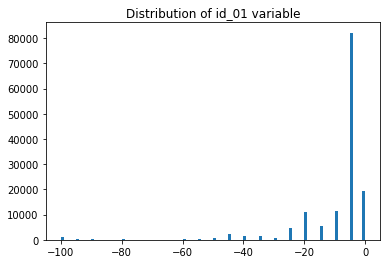

In [ ]:
plt.hist(train['id_01'], bins=100);
plt.title('Distribution of id_01 variable');

In [ ]:
train['id_03'].value_counts(dropna=False, normalize=True).head()

NaN    0.887689
0.0    0.108211
1.0    0.001461
3.0    0.001131
2.0    0.000713
Name: id_03, dtype: float64

In [ ]:
train['id_04'].value_counts(dropna=False, normalize=True).head()

 NaN    0.887689
 0.0    0.111320
-5.0    0.000224
-6.0    0.000166
-8.0    0.000108
Name: id_04, dtype: float64

In [ ]:
drop_list2 = ['id_03','id_04']
train.drop(drop_list2, axis=1, inplace=True)

In [ ]:
import argparse
import logging
import os

import pandas as pd
import numpy as np
from itertools import combinations


def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--data-dir', type=str, default='/opt/ml/processing/input')
    parser.add_argument('--output-dir', type=str, default='/opt/ml/processing/output')
    parser.add_argument('--transactions', type=str, default='transaction.csv', help='name of file with transactions')
    parser.add_argument('--identity', type=str, default='identity.csv', help='name of file with identity info')
    parser.add_argument('--id-cols', type=str, default='', help='comma separated id cols in transactions table')
    parser.add_argument('--cat-cols', type=str, default='', help='comma separated categorical cols in transactions')
    parser.add_argument('--train-data-ratio', type=float, default=0.8, help='fraction of data to use in training set')
    parser.add_argument('--construct-homogeneous', action="store_true", default=False,
                        help='use bipartite graphs edgelists to construct homogenous graph edgelist')
    return parser.parse_args()


def get_logger(name):
    logger = logging.getLogger(name)
    log_format = '%(asctime)s %(levelname)s %(name)s: %(message)s'
    logging.basicConfig(format=log_format, level=logging.INFO)
    logger.setLevel(logging.INFO)
    return logger


def load_data(data_dir, transaction_data, identity_data, train_data_ratio, output_dir):
    transaction_df = pd.read_csv(os.path.join(data_dir, transaction_data))
    logging.info("Shape of transaction data is {}".format(transaction_df.shape))
    logging.info("# Tagged transactions: {}".format(len(transaction_df) - transaction_df.isFraud.isnull().sum()))

    identity_df = pd.read_csv(os.path.join(data_dir, identity_data))
    logging.info("Shape of identity data is {}".format(identity_df.shape))

    # extract out transactions for test/validation
    n_train = int(transaction_df.shape[0]*train_data_ratio)
    test_ids = transaction_df.TransactionID.values[n_train:]

    get_fraud_frac = lambda series: 100 * sum(series)/len(series)
    logging.info("Percent fraud for train transactions: {}".format(get_fraud_frac(transaction_df.isFraud[:n_train])))
    logging.info("Percent fraud for test transactions: {}".format(get_fraud_frac(transaction_df.isFraud[n_train:])))
    logging.info("Percent fraud for all transactions: {}".format(get_fraud_frac(transaction_df.isFraud)))

    with open(os.path.join(output_dir, 'test.csv'), 'w') as f:
        f.writelines(map(lambda x: str(x) + "\n", test_ids))
    logging.info("Wrote test to file: {}".format(os.path.join(output_dir, 'test.csv')))

    return transaction_df, identity_df, test_ids


def get_features_and_labels(transactions_df, transactions_id_cols, transactions_cat_cols, output_dir):
    # Get features
    non_feature_cols = ['isFraud', 'TransactionDT'] + transactions_id_cols.split(",")
    feature_cols = [col for col in transactions_df.columns if col not in non_feature_cols]
    logging.info("Categorical columns: {}".format(transactions_cat_cols.split(",")))
    features = pd.get_dummies(transactions_df[feature_cols], columns=transactions_cat_cols.split(",")).fillna(0)
    features['TransactionAmt'] = features['TransactionAmt'].apply(np.log10)
    logging.info("Transformed feature columns: {}".format(list(features.columns)))
    logging.info("Shape of features: {}".format(features.shape))
    features.to_csv(os.path.join(output_dir, 'features.csv'), index=False, header=False)
    logging.info("Wrote features to file: {}".format(os.path.join(output_dir, 'features.csv')))

    # Get labels
    transactions_df[['TransactionID', 'isFraud']].to_csv(os.path.join(output_dir, 'tags.csv'), index=False)
    logging.info("Wrote labels to file: {}".format(os.path.join(output_dir, 'tags.csv')))


def get_relations_and_edgelist(transactions_df, identity_df, transactions_id_cols, output_dir):
    # Get relations
    edge_types = transactions_id_cols.split(",") + list(identity_df.columns)
    logging.info("Found the following distinct relation types: {}".format(edge_types))
    id_cols = ['TransactionID'] + transactions_id_cols.split(",")
    full_identity_df = transactions_df[id_cols].merge(identity_df, on='TransactionID', how='left')
    logging.info("Shape of identity columns: {}".format(full_identity_df.shape))

    # extract edges
    edges = {}
    for etype in edge_types:
        edgelist = full_identity_df[['TransactionID', etype]].dropna()
        edgelist.to_csv(os.path.join(output_dir, 'relation_{}_edgelist.csv').format(etype), index=False, header=True)
        logging.info("Wrote edgelist to: {}".format(os.path.join(output_dir, 'relation_{}_edgelist.csv').format(etype)))
        edges[etype] = edgelist
    return edges


def create_homogeneous_edgelist(edges, output_dir):
    homogeneous_edges = []
    for etype, relations in edges.items():
        for edge_relation, frame in relations.groupby(etype):
            new_edges = [(a, b) for (a, b) in combinations(frame.TransactionID.values, 2)
                         if (a, b) not in homogeneous_edges and (b, a) not in homogeneous_edges]
            homogeneous_edges.extend(new_edges)

    with open(os.path.join(output_dir, 'homogeneous_edgelist.csv'), 'w') as f:
        f.writelines(map(lambda x: "{}, {}\n".format(x[0], x[1]), homogeneous_edges))
    logging.info("Wrote homogeneous edgelist to file: {}".format(os.path.join(output_dir, 'homogeneous_edgelist.csv')))

In [ ]:
if name == '__main__':
    logging = get_logger(name)

    args = parse_args()

    transactions, identity, test_transactions = load_data(args.data_dir,
                                                          args.transactions,
                                                          args.identity,
                                                          args.train_data_ratio,
                                                          args.output_dir)

    get_features_and_labels(transactions, args.id_cols, args.cat_cols, args.output_dir)
    relational_edges = get_relations_and_edgelist(transactions, identity, args.id_cols, args.output_dir)

    if args.construct_homogeneous:
        create_homogeneous_edgelist(relational_edges, args.output_dir)

In [ ]:
def get_obj_cols(df, k):
    """
    Function returns the object features in the dataset
    """
    cols = list(df.columns)
    obj_cols = [cols[i[0]] for i in enumerate(df.dtypes) if i[1] == 'object']
    return obj_cols

In [ ]:
def pre_processing(df, k):
    """
    Function returns preprocess dataframe for training
    
    Args:
        df: loaded dataframe
        nrc: non relevant columns
        oc: object type columns
        
    Returns:
        df_trans: preprocessed dataframe
    """
    
    object_columns = get_obj_cols(df, k)
    object_df = pd.get_dummies(df, columns=object_columns)
    
    for i in object_df.columns[object_df.isnull().any(axis=0)]:
        object_df[i].fillna(object_df[i].median(), inplace=True)
    
    cols = list(object_df.columns)
    q_transform = preprocessing.QuantileTransformer()
    np_trans = q_transform.fit_transform(object_df)
    df_trans = pd.DataFrame(np_trans)
    df_trans.columns = object_df.columns
    
    return df_trans

In [ ]:
df_train = pre_processing(train, 20)

In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split
import subprocess
import argparse
import os

def get_args():

    args_parser = argparse.ArgumentParser()
    
    args_parser.add_argument(
          '--nrc',
          help="""
          Path of the csv file for 
          """,
          type=str
    )
    
    args_parser.add_argument(
          '--datapath',
          help="""
          Path of the csv file for 
          """,
          type=str
    )
    
    args_parser.add_argument(
          '--t',
          help="""
          target variable
          """,
          type=str
    )
    
    args_parser.add_argument(
          '--k',
          help="""
          number to limit the categorical variables conversion to numerical
          """,
          type=str
    )
    
    args_parser.add_argument(
          '--outputpath',
          help="""
          path to where processed files are saved
          """,
          type=str
    )
    
    return args_parser.parse_args()

def get_obj_cols(df, k):
    """
    Function returns the object features in the dataset
    """
    cols = list(df.columns)
    obj_cols = [cols[i[0]] for i in enumerate(df.dtypes) if i[1] == 'object']
    for x in obj_cols:
        if len(df[x].value_counts()) > len(df)/k:
            obj_cols.remove(x)
            df.drop([x], axis=1, inplace=True)
    return obj_cols

def pre_processing(df, Y, k, nrc):
    """
    Function returns preprocess dataframe for training
    
    Args:
        df: loaded dataframe
        nrc: non relevant columns
        oc: object type columns
        
    Returns:
        df_trans: preprocessed dataframe
    """
    
    # Filling missing values
    for i in df.columns[df.isnull().any(axis=0)]:
        df[i].fillna(df[i].mean(), inplace=True)
    print("The sum of the missing values in the dataframe,", df.isnull().sum())
    
    # Filling dummies one-hot encoding
    non_relevant_columns = nrc.split(',')
    object_columns = get_obj_cols(df, k)
    object_df = pd.get_dummies(df, columns=object_columns)
    object_df.drop(non_relevant_columns, axis=1, inplace=True)
    print("The datatypes in the dataframe are", object_df.dtypes)
    
    # Quantile transformers
    cols = list(object_df.columns)
    q_transform = preprocessing.QuantileTransformer()
    np_trans = q_transform.fit_transform(object_df)
    df_trans = pd.DataFrame(np_trans)
    df_trans.columns = object_df.columns
    df_con = pd.concat([df_trans, Y], axis=1)
    df_con.to_csv('preprocessed.csv', index=False)
    return "Success, file saved as preprocessed.csv"

if __name__ == "__main__":
    
    args = get_args()
    df_p = args.datapath
    outputpath = args.outputpath
    target = args.t
    nrc = args.nrc
    k = int(args.k)
    
    main_path = os.getcwd()
    subprocess.call(['aws', 's3', 'cp', str(df_p), './'])
    
    dp = os.path.join(main_path, 'data.csv')
    df = pd.read_csv(dp)
    Y = df[target]
    df.drop([target], axis=1, inplace=True)
    pre_processing(df, Y, k, nrc)
    
    subprocess.call(['aws', 's3', 'cp', 'preprocessed.csv', str(outputpath)])

usage: ipykernel_launcher.py [-h] [--nrc NRC] [--datapath DATAPATH] [--t T]
                             [--k K] [--outputpath OUTPUTPATH]
ipykernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-89f73ba0-848f-4b47-902f-1deef9e8911b.json


SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
''' This file defines the anomaly detection using graph metrics '''

import pandas as pd
import seaborn
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from sqlalchemy import create_engine
import Get_Data as get_data
import statistical_analysis
import graph_analysis
import numpy as np
#import pdb

GRAPH_THRESHOLD = 2 # 2X the std out of PCA


def Generate_Edgelist (df,filename) :
	"""
	Description: This function exports an edgelist from the DataFrame.
	INPUT: 
	       df - type: DataFrame - This is the cleaned up datafram of the call log that contains the caller, callee columns
	       filename  - type: string - This is the filename that will store the edgelist
	OUTPUT: No output. Just stores the file in the file system
	"""

	edgelist = df[["callgno","calldno"]]
	edgelist = edgelist.astype(str)
	edgelist.to_csv(filename,index=False)

# Now for the graph analysis

def Generate_Graph (total_edges_filename,Anomalies):
	"""
	Description: This function generates a subgraph of all the anomaly nodes.
	INPUT: 
			total_edges_filename: This is a filename that has the edges. Comes from Generate_Edgelist
			Anomalies: This is a list of nodes that are anomalies
	OUTPUT: returns the subgraph in networkx format
	"""
	# this function builds the subgraph for the anomalies set. TBD : Build the subgraph using a longer time window
	TotalGraph = nx.read_edgelist(total_edges_filename,delimiter=',')
	Anomalies_Subgraph = nx.Graph()
	for anomaly in Anomalies:
		Anomalies_Subgraph = nx.compose(Anomalies_Subgraph,nx.ego_graph(TotalGraph,anomaly,radius=3))
	print len(Anomalies_Subgraph.nodes())
	return Anomalies_Subgraph

def GraphAnalysis(Anomalies_Subgraph):
	# Generate an output where the indexes are the Anomalies phone numbers and the columns are the graph metrics
	pagerank_matrix = nx.pagerank(Anomalies_Subgraph,max_iter=200)
	pagerank_matrix_df = pd.DataFrame.from_dict(pagerank_matrix,orient='index')
	pagerank_matrix_df.column=["Page Rank"]

	trianglecount_matrix = nx.triangles(Anomalies_Subgraph)
	trianglecount_matrix_df = pd.DataFrame.from_dict(trianglecount_matrix,orient='index')
	trianglecount_matrix_df.column=["Triangle Count"]
	trianglecount_matrix_df.describe()

	body = pd.merge(pagerank_matrix_df,trianglecount_matrix_df,right_index=True,left_index=True)
	body.head()
	body = body.reset_index()
	body.columns = ["Phone Number", "Page Rank", "Triangle Count"]
	return body

def Draw_Suspect_Fraud_Node (suspect, Anomalies_Subgraph):
	import d3py
	import networkx as nx   
	import random 
	Anomalies_Subgraph = nx.ego_graph(Anomalies_Subgraph,suspect,radius=3)
	name = str(random.random()) + "_graph"
	with d3py.NetworkXFigure(Anomalies_Subgraph, name=name,width=1000, height=1000) as p:
	    p += d3py.ForceLayout()
	    p.css['.node'] = {'fill': 'blue', 'stroke': 'magenta'}
	    p.show() 


def Find_Graph_Anomalies (graph_metrics_df):
	# This function takes in the graph metrics and performs an anomaly analysis to identify the graph anomalies and returns those nodes
	# should scale the metrics first and then do one class SVM
	from sklearn.decomposition import PCA, KernelPCA
	X=graph_metrics_df.values[:,[1,2]]
	pca = PCA(n_components=2)
	pca.fit(X)

	X_lowed = pca.transform(np.real(X))
	#pdb.set_trace()
	temp = X_lowed.copy()
	temp[:,1]=temp[:,0]
	temp[:,0]=range(0,len(temp))
	np.savetxt("./static/PCA_Results.csv", temp, delimiter=",", header = "Index, PCA Transform")
#	fig, ax = plt.subplots()
#	plt.plot(pca.explained_variance_)
	plt.plot(X_lowed[:,0],'o')
	plt.xlabel('Index')
	plt.ylabel('Highest Explanatory PCA Dimension')
	plt.title('Anomalies on Graph Metrics using PCA')
	plt.savefig("./static/PCA_Analysis.png",bbox_inches='tight')
	plt.close('all')

	NumOfFrauds = len(X_lowed[abs(X_lowed[:,0]) > (GRAPH_THRESHOLD*abs(np.std(X_lowed[:,0])))])
	print "num of frauds ", NumOfFrauds
	indices = np.argsort(X_lowed[:,0])[:len(X_lowed)-(NumOfFrauds+1):-1]
	graph_metrics_df["Phone Number"].apply(lambda x : x.encode('utf-8'))
	SuspectFraudPhoneNumbers = graph_metrics_df.iloc[indices]["Phone Number"].values
	return SuspectFraudPhoneNumbers


SyntaxError: ignored

In [ ]:
# Splitting data into 4 sets
# 1. Shuffle/randomize data
# 2. One-hot encoding
# 3. Normalize
# 4. Splitting up X/y values
# 5. Convert data_frames to numpy arrays (float32)
# 6. Splitting the final data into X/y train/test

# Shuffle and randomize data
shuffled_data = train.sample(frac=1)
# Change Class column into Class_0 ([1 0] for legit data) and Class_1 ([0 1] for fraudulent data)
one_hot_data = pd.get_dummies(shuffled_data, columns=['isFraud'])
# Change all values into numbers between 0 and 1
normalized_data = (one_hot_data - one_hot_data.min()) / (one_hot_data.max() - one_hot_data.min())
# Store just columns V1 through V28 in df_X and columns Class_0 and Class_1 in df_y
df_X = normalized_data.drop(['Class_0', 'Class_1'], axis=1)
df_y = normalized_data[['Class_0', 'Class_1']]
# Convert both data_frames into np arrays of float32
ar_X, ar_y = np.asarray(df_X.values, dtype='float32'), np.asarray(df_y.values, dtype='float32')
# Allocate first 80% of data into training data and remaining 20% into testing data
train_size = int(0.8 * len(ar_X))
(raw_X_train, raw_y_train) = (ar_X[:train_size], ar_y[:train_size])
(raw_X_test, raw_y_test) = (ar_X[train_size:], ar_y[train_size:])

# Gets a percent of fraud vs legit transactions (0.0017% of transactions are fraudulent)
count_legit, count_fraud = np.unique(train['isFraud'], return_counts=True)[1]
fraud_ratio = float(count_fraud / (count_legit + count_fraud))
print('Percent of fraudulent transactions: ', fraud_ratio)

# Applies a logit weighting of 578 (1/0.0017) to fraudulent transactions to cause model to pay more attention to them
weighting = 1 / fraud_ratio
raw_y_train[:, 1] = raw_y_train[:, 1] * weighting

import tensorflow as tf

# 30 cells for the input
input_dimensions = ar_X.shape[1]
# 2 cells for the output
output_dimensions = ar_y.shape[1]
# 100 cells for the 1st layer
num_layer_1_cells = 100
# 150 cells for the second layer
num_layer_2_cells = 150

# We will use these as inputs to the model when it comes time to train it (assign values at run time)
X_train_node = tf.placeholder(tf.float32, [None, input_dimensions], name='X_train')
y_train_node = tf.placeholder(tf.float32, [None, output_dimensions], name='y_train')

# We will use these as inputs to the model once it comes time to test it
X_test_node = tf.constant(raw_X_test, name='X_test')
y_test_node = tf.constant(raw_y_test, name='y_test')

# First layer takes in input and passes output to 2nd layer
weight_1_node = tf.Variable(tf.zeros([input_dimensions, num_layer_1_cells]), name='weight_1')
biases_1_node = tf.Variable(tf.zeros([num_layer_1_cells]), name='biases_1')

# Second layer takes in input from 1st layer and passes output to 3rd layer
weight_2_node = tf.Variable(tf.zeros([num_layer_1_cells, num_layer_2_cells]), name='weight_2')
biases_2_node = tf.Variable(tf.zeros([num_layer_2_cells]), name='biases_2')

# Third layer takes in input from 2nd layer and outputs [1 0] or [0 1] depending on fraud vs legit
weight_3_node = tf.Variable(tf.zeros([num_layer_2_cells, output_dimensions]), name='weight_3')
biases_3_node = tf.Variable(tf.zeros([output_dimensions]), name='biases_3')


# Function to run an input tensor through the 3 layers and output a tensor that will give us a fraud/legit result
# Each layer uses a different function to fit lines through the data and predict whether a given input tensor will \
#   result in a fraudulent or legitimate transaction
def network(input_tensor):
    # Sigmoid fits modified data well
    layer1 = tf.nn.sigmoid(tf.matmul(input_tensor, weight_1_node) + biases_1_node)
    # Dropout prevents model from becoming lazy and over confident
    layer2 = tf.nn.dropout(tf.nn.sigmoid(tf.matmul(layer1, weight_2_node) + biases_2_node), 0.85)
    # Softmax works very well with one hot encoding which is how results are outputted
    layer3 = tf.nn.softmax(tf.matmul(layer2, weight_3_node) + biases_3_node)
    return layer3


# Used to predict what results will be given training or testing input data
# Remember, X_train_node is just a placeholder for now. We will enter values at run time
y_train_prediction = network(X_train_node)
y_test_prediction = network(X_test_node)

# Cross entropy loss function measures differences between actual output and predicted output
cross_entropy = tf.losses.softmax_cross_entropy(y_train_node, y_train_prediction)

# Adam optimizer function will try to minimize loss (cross_entropy) but changing the 3 layers' variable values at a
#   learning rate of 0.005
optimizer = tf.train.AdamOptimizer(0.005).minimize(cross_entropy)


# Function to calculate the accuracy of the actual result vs the predicted result
def calculate_accuracy(actual, predicted):
    actual = np.argmax(actual, 1)
    predicted = np.argmax(predicted, 1)
    return (100 * np.sum(np.equal(predicted, actual)) / predicted.shape[0])

num_epochs = 100

import time

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(num_epochs):

        start_time = time.time()

        _, cross_entropy_score = session.run([optimizer, cross_entropy],
                                             feed_dict={X_train_node: raw_X_train, y_train_node: raw_y_train})

        if epoch % 10 == 0:
            timer = time.time() - start_time

            print('Epoch: {}'.format(epoch), 'Current loss: {0:.4f}'.format(cross_entropy_score),
                  'Elapsed time: {0:.2f} seconds'.format(timer))

            final_y_test = y_test_node.eval()
            final_y_test_prediction = y_test_prediction.eval()
            final_accuracy = calculate_accuracy(final_y_test, final_y_test_prediction)
            print("Current accuracy: {0:.2f}%".format(final_accuracy))

    final_y_test = y_test_node.eval()
    final_y_test_prediction = y_test_prediction.eval()
    final_accuracy = calculate_accuracy(final_y_test, final_y_test_prediction)
    print("Final accuracy: {0:.2f}%".format(final_accuracy))

final_fraud_y_test = final_y_test[final_y_test[:, 1] == 1]
final_fraud_y_test_prediction = final_y_test_prediction[final_y_test[:, 1] == 1]
final_fraud_accuracy = calculate_accuracy(final_fraud_y_test, final_fraud_y_test_prediction)
print('Final fraud specific accuracy: {0:.2f}%'.format(final_fraud_accuracy))


In [7]:
import pandas as pd
from py2neo import Graph

In [23]:
import pandas as pd

df = pd.DataFrame({'ID':[1,2,3,4,5,6], 
                   'First Name':['Felix', 'Jean', 'James', 'Daphne', 'James', 'Peter'], 
                   'Family Name': ['Revert', 'Durand', 'Wright', 'Hull', 'Conrad', 'Donovan'],
                   'Phone number': ['+33 6 12 34 56 78', '+33 7 00 00 00 00', '+33 6 12 34 56 78', '+33 6 99 99 99 99', '+852 0123 4567', '+852 0123 4567'],
                   'Email': ['felix.revert@gmail.com', 'jean.durand@gmail.com', 'j.custom@gmail.com', pd.np.nan, 'j.custom@gmail.com', pd.np.nan]})


# G.add_nodes_from(df.ID.unique().tolist(), label='user')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  import sys


In [24]:
column_edge = 'Phone number'
column_ID = 'ID'

data_to_merge = df[[column_ID, column_edge]].dropna(subset=[column_edge]).drop_duplicates() # select columns, remove NaN

# To create connections between people who have the same number,
# join data with itself on the 'ID' column.
data_to_merge = data_to_merge.merge(
    data_to_merge[[column_ID, column_edge]].rename(columns={column_ID:column_ID+"_2"}), 
    on=column_edge
)
df.head()

,ID,First Name,Family Name,Phone number,Email
0,1,Felix,Revert,+33 6 12 34 56 78,felix.revert@gmail.com
1,2,Jean,Durand,+33 7 00 00 00 00,jean.durand@gmail.com
2,3,James,Wright,+33 6 12 34 56 78,j.custom@gmail.com
3,4,Daphne,Hull,+33 6 99 99 99 99,NaN
4,5,James,Conrad,+852 0123 4567,j.custom@gmail.com


In [25]:
data_to_merge

,ID,Phone number,ID_2
0,1,+33 6 12 34 56 78,1
1,1,+33 6 12 34 56 78,3
2,3,+33 6 12 34 56 78,1
3,3,+33 6 12 34 56 78,3
4,2,+33 7 00 00 00 00,2
5,4,+33 6 99 99 99 99,4
6,5,+852 0123 4567,5
7,5,+852 0123 4567,6
8,6,+852 0123 4567,5
9,6,+852 0123 4567,6


In [11]:
data_to_merge = df[[column_ID, column_edge]].dropna(subset=[column_edge]).drop_duplicates() # select columns, remove NaN

In [26]:
# By joining the data with itself, people will have a connection with themselves.
# Remove self connections, to keep only connected people who are different.
d = data_to_merge[~(data_to_merge[column_ID]==data_to_merge[column_ID+"_2"])] \
    .dropna()[[column_ID, column_ID+"_2", column_edge]]
    
# To avoid counting twice the connections (person 1 connected to person 2 and person 2 connected to person 1)
# we force the first ID to be "lower" then ID_2
d.drop(d.loc[d[column_ID+"_2"]<d[column_ID]].index.tolist(), inplace=True)

In [27]:
d.head()

,ID,ID_2,Phone number
1,1,3,+33 6 12 34 56 78
7,5,6,+852 0123 4567


In [28]:
import networkx as nx

G = nx.from_pandas_edgelist(df=d, source=column_ID, target=column_ID+'_2', edge_attr=column_edge)

G.add_nodes_from(nodes_for_adding=df.ID.tolist())

In [29]:
G.nodes()

NodeView((1, 3, 5, 6, 2, 4))

In [22]:
#https://towardsdatascience.com/getting-started-with-graph-analysis-in-python-with-pandas-and-networkx-5e2d2f82f18e

In [30]:
column_edge = 'Email'
column_ID = 'ID'

data_to_merge = df[[column_ID, column_edge]].dropna(subset=[column_edge]).drop_duplicates()

data_to_merge = data_to_merge.merge(
    data_to_merge[[column_ID, column_edge]].rename(columns={column_ID:column_ID+"_2"}), 
    on=column_edge
)

d = data_to_merge[~(data_to_merge[column_ID]==data_to_merge[column_ID+"_2"])] \
    .dropna()[[column_ID, column_ID+"_2", column_edge]]

d.drop(d.loc[d[column_ID+"_2"]<d[column_ID]].index.tolist(), inplace=True)

In [31]:
d

,ID,ID_2,Email
3,3,5,j.custom@gmail.com


In [32]:
# Create the connections in the graph
links_attributes = {tuple(row[[column_ID, column_ID+"_2"]]): {column_edge: row[column_edge]} for i,row in d.iterrows()}

G.add_edges_from(links_attributes) # create the connection, without attribute. Check it with G.get_edge_data(3,5)
nx.set_edge_attributes(G=G, values=links_attributes) # adds the attribute. Check it with G.get_edge_data(3,5)

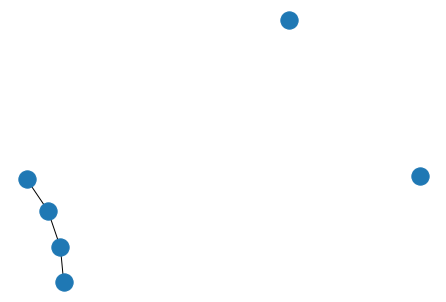

In [33]:
%matplotlib inline
nx.draw(G)

In [34]:
{row[column_ID]:row['First Name'] +' '+ row['Family Name'] for i,row in df.iterrows()}

{1: 'Felix Revert',
 2: 'Jean Durand',
 3: 'James Wright',
 4: 'Daphne Hull',
 5: 'James Conrad',
 6: 'Peter Donovan'}

In [35]:
nx.set_node_attributes(G, {row[column_ID]:{'Name': row['First Name'] +' '+ row['Family Name']} for i,row in df.iterrows()})

In [36]:
EDGE_SIZE = {
    'Phone number': 2,
    'Email': 1,
}

EDGE_COLOR = {
    'Phone number': 'purple',
    'Email': 'red',
}

def clean_edge(edge):
    s.edge[edge[0], edge[1]].values()

def c_(list_edges): return [a for a in list_edges if a in list(EDGE_COLOR.keys())]
    
# For nx.Graph()
def edge_sizes(s): return [EDGE_SIZE[c_(list(s.edges[edge[0], edge[1]].keys()))[-1]] for edge in s.edges()] # /!\ multiple links => one size
def edge_colors(s): return [EDGE_COLOR[c_(list(s.edges[edge[0], edge[1]].keys()))[-1]] for edge in s.edges()] # /!\ multiple links => one color

# For nx.MultiDiGraph()
# def edge_sizes(s): return [EDGE_SIZE[s.edge[edge[0]][edge[1]][0]['label']] for edge in s.edges()] # /!\ multiple links => one size
# def edge_colors(s): return [EDGE_COLOR[s.edge[edge[0]][edge[1]][0]['label']] for edge in s.edges()] # /!\ multiple links => one color

def draw(s):
    pos = nx.spring_layout(s, scale=0.5)
    node_labels = dict((n,d['Name']) for n,d in s.nodes(data=True))
#     labels = {**node_labels, **edge_labels}
    nx.draw(s, pos=pos, width=edge_sizes(s), edge_color=edge_colors(s), alpha=0.8, arrows=False, node_color='lightgrey', node_size=400,
            labels=node_labels, 
            font_color='black', font_size=8, font_weight='bold',
           )
    edge_labels = dict(((u,v),list(d.values())[0]) for u,v,d in G.edges(data=True))
    nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, font_size=8)

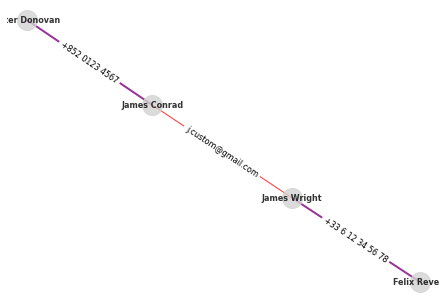

In [37]:
draw(nx.ego_graph(G=G, n=1, radius=3))

In [38]:
#Automated detection of strange patterns
degrees = list(nx.degree(G))
pd.DataFrame([list(d) for d in degrees], columns=['ID', 'degree']).sort_values('degree', ascending=False).head(5)

,ID,degree
1,3,2
2,5,2
0,1,1
3,6,1
4,2,0


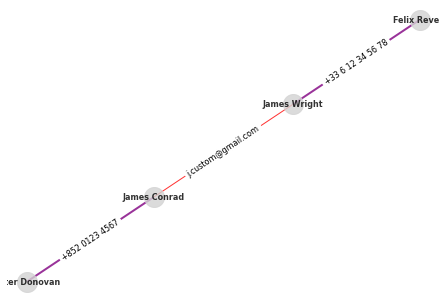

In [39]:
draw(nx.ego_graph(G=G, n=3, radius=2))

https://towardsdatascience.com/introduction-to-graphs-part-1-2de6cda8c5a5

In [ ]:
G = nx.from_pandas_edgelist(df, "source", "target", edge_attr=True, create_using=nx.Graph())
